[I 2025-03-04 17:28:33,664] A new study created in memory with name: no-name-acdef74f-3632-4320-af39-e52221912f58
[I 2025-03-04 17:28:34,586] Trial 0 finished with value: 0.8761061946902655 and parameters: {'dropout_rate': 0.18076652159693776, 'learning_rate': 0.00016627076122252817, 'batch_size': 32, 'l1_lambda': 0.001517351950392802}. Best is trial 0 with value: 0.8761061946902655.
[I 2025-03-04 17:28:35,083] Trial 1 finished with value: 0.8938053097345132 and parameters: {'dropout_rate': 0.40033112783458435, 'learning_rate': 0.0013376246798262662, 'batch_size': 64, 'l1_lambda': 0.0003532805179816271}. Best is trial 1 with value: 0.8938053097345132.
[I 2025-03-04 17:28:35,900] Trial 2 finished with value: 0.911504424778761 and parameters: {'dropout_rate': 0.22128200794643554, 'learning_rate': 0.0002266954122516919, 'batch_size': 32, 'l1_lambda': 0.001415729279259256}. Best is trial 2 with value: 0.911504424778761.
[I 2025-03-04 17:28:36,412] Trial 3 finished with value: 0.90265486725

Best Hyperparameters: {'dropout_rate': 0.3088093527861758, 'learning_rate': 0.002615496439647086, 'batch_size': 64, 'l1_lambda': 3.100110696994828e-05}

=== 🚀 Training Performance ===
Training Accuracy: 0.9272

Training Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.83      0.88        54
           1       0.91      0.91      0.91        54
           2       0.93      0.97      0.95       153

    accuracy                           0.93       261
   macro avg       0.93      0.90      0.91       261
weighted avg       0.93      0.93      0.93       261



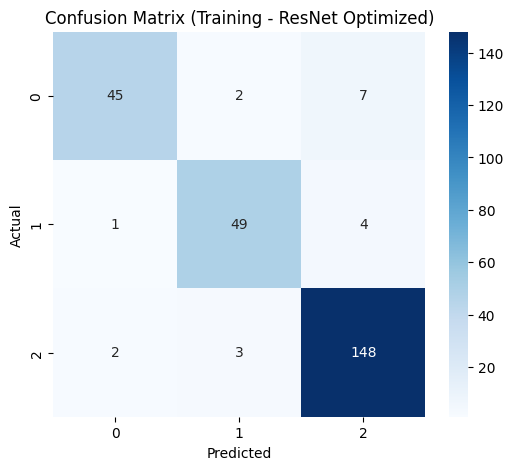


=== 🚀 Testing Performance ===
Testing Accuracy: 0.9204

Testing Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        23
           1       0.81      0.92      0.86        24
           2       0.98      0.94      0.96        66

    accuracy                           0.92       113
   macro avg       0.89      0.91      0.90       113
weighted avg       0.92      0.92      0.92       113



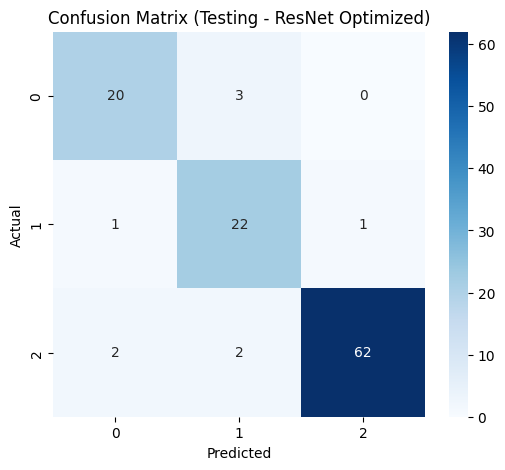

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import optuna  # Hyperparameter tuning
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

# Load dataset
data = pd.read_csv(r"C:\Users\Pradeep Hariharan\Desktop\Project\Sleep\updated_data.csv")

# Encode categorical variables
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  

# Encode target variable
le_target = LabelEncoder()
data['Sleep Disorder'] = le_target.fit_transform(data['Sleep Disorder'])

# Train-test split
X = data.drop(columns=['Sleep Disorder'])
y = data['Sleep Disorder']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

class ResNetBlock(nn.Module):
    """Optimized Residual Block with Dropout, Batch Normalization, and L1 Regularization"""
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.3):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, input_dim)
        self.bn2 = nn.BatchNorm1d(input_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x  # Skip connection
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out += identity  # Add skip connection
        out = self.relu(out)
        return out

class ResNetOptimizedL1(nn.Module):
    """ResNet with Optimizations: Dropout, BatchNorm, Hyperparameter Tuning, and L1 Regularization"""
    def __init__(self, input_dim, num_classes, dropout_rate, l1_lambda):
        super(ResNetOptimizedL1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.resblock1 = ResNetBlock(64, 128, dropout_rate)
        self.resblock2 = ResNetBlock(64, 128, dropout_rate)
        self.fc2 = nn.Linear(64, num_classes)
        self.l1_lambda = l1_lambda  # L1 Regularization Strength
        self.init_weights()  # Apply Xavier Initialization

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.fc2(x)
        return x  

    def init_weights(self):
        """Apply Xavier initialization to layers"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def l1_regularization(self):
        """Compute L1 regularization loss"""
        l1_norm = sum(torch.norm(param, 1) for param in self.parameters())
        return self.l1_lambda * l1_norm

def objective(trial):
    """Objective function for hyperparameter tuning"""
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.01, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    l1_lambda = trial.suggest_float("l1_lambda", 1e-5, 1e-2, log=True)  # L1 Regularization Strength

    # Define model
    model = ResNetOptimizedL1(input_dim=X_train.shape[1], num_classes=len(y.unique()), dropout_rate=dropout_rate, l1_lambda=l1_lambda)

    # Loss, Optimizer, and Learning Rate Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training
    epochs = 20
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch) + model.l1_regularization()  # Add L1 loss
            loss.backward()
            optimizer.step()
        scheduler.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).argmax(dim=1).numpy()
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
best_params = study.best_params
print("Best Hyperparameters:", best_params)

final_model = ResNetOptimizedL1(input_dim=X_train.shape[1], num_classes=len(y.unique()), dropout_rate=best_params["dropout_rate"], l1_lambda=best_params["l1_lambda"])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params["learning_rate"])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)

# Training
epochs = 50
for epoch in range(epochs):
    final_model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = final_model(X_batch)
        loss = criterion(outputs, y_batch) + final_model.l1_regularization()  # L1 Loss
        loss.backward()
        optimizer.step()
    scheduler.step()

final_model.eval()

with torch.no_grad():
    y_train_pred = final_model(X_train_tensor).argmax(dim=1).numpy()
    y_test_pred = final_model(X_test_tensor).argmax(dim=1).numpy()

# Compute accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)

print("\n=== 🚀 Training Performance ===")
print(f"Training Accuracy: {train_accuracy:.4f}")
print("\nTraining Classification Report:\n", train_report)

# Training Confusion Matrix - Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Training - ResNet Optimized)')
plt.show()

test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\n=== 🚀 Testing Performance ===")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print("\nTesting Classification Report:\n", test_report)

# Testing Confusion Matrix - Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing - ResNet Optimized)')
plt.show()

